In [1]:
import requests
from bs4 import BeautifulSoup
import nltk
from nltk.tokenize import word_tokenize 
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
import xgboost as xgb
from sklearn.metrics import mean_squared_error, r2_score
import time
pd.set_option('display.max_columns', 1000)

In [2]:
# load make-mkId
makeid_dict=pd.read_csv('make-mkId.csv', index_col='Unnamed: 0').to_dict()['0']
makes=list(makeid_dict.keys())

In [3]:
# input make, zipcode
MAKE='Jeep'
zip_code=75080

###
name=[]
price=[]
mileage=[]
certified=[]
url='https://www.cars.com/for-sale/searchresults.action/?mkId={}&page={}&perPage=100&rd=30&searchSource=PAGINATION&sort=relevance&stkTypId=28881&zc={}'
errornum=0
j=1
while j < 51:
    result1= requests.get(url.format(int(makeid_dict[MAKE]),j,zip_code)) # page number, 1 min, 50 max
    if result1.status_code==200: # good connection
        # get content
        source=result1.content
        soup=BeautifulSoup(source,'lxml')
        try: 
            # see if no so many pages but may cause issues(due to unstable connection)
            int(soup.find('a',class_='selected').attrs['data-page'])==j 
            # get car info on one page
            for item in soup.find_all('div', class_='shop-srp-listings__listing-container'):
                name+=[item.find('h2').string]
                price+=[item.find('span',class_='listing-row__price').string]
                mileage+=[item.find('span',class_='listing-row__mileage').string]
                certified+=[item.find('div',class_='listing-row__stocktype').string]
        except:
            break
    elif result1.status_code==500: # bad connection, retry this page. 
        j=j-1
        errornum+=1
    if errornum>50: # if retry too many times, raise a notice and break
        print('check connection')
        break
    # print(j)
    j+=1
    # print('page{}finished'.format(j))
print('total pages {}'.format(j-1))
# get year make model
# some with no mileage
textmile=[]
rows_to_drop=[]
for i,j in enumerate(mileage):
    try:
        textmile+=[int(nltk.word_tokenize(j)[0].replace(',' , ''))] # replace '1,000' to 1000 int
    except:
        textmile+=[np.nan]
        rows_to_drop+=[i]
textyear=[int(nltk.word_tokenize(i)[0]) for i in name]
textmake=[nltk.word_tokenize(i)[1] for i in name]
# textmodel=[nltk.word_tokenize(i)[2] for i in name] 

# some with no model
textmodel=[]
for i,j in enumerate(name):
    try:
        textmodel+=[nltk.word_tokenize(j)[2]] # first token of the model name
    except:
        textmodel+=[np.nan]
        rows_to_drop+=[i]

# some with no price
textp=[]
for i,j in enumerate(price):
    try:
        textp+=[int(nltk.word_tokenize(j)[1].replace(',' , ''))]
    except:
        textp+=[np.nan]
        rows_to_drop+=[i]
textcert=[1 if i==None else 0 for i in certified] # certified uses a sublabel thus result in none

total pages 16


In [9]:
for i in name:
    if len(nltk.word_tokenize(i))<3:
        print(i)


                            1973 Jeep
                        


In [4]:
usedcarinfo=pd.DataFrame([textmake,textyear,textmodel,textmile,textcert,textp]).T
usedcarinfo.rename(columns={0:'make',1:'year',2:'model',3:'mileage',4:'certified',5:'price'},inplace=True)
usedcarinfo.drop(rows_to_drop,inplace= True)
usedcarinfo=usedcarinfo.reset_index().drop(columns='index')
# convert type object to numeric
columns_to_convert=['year','mileage','certified','price']
for i in columns_to_convert:
    usedcarinfo[i]=pd.to_numeric(usedcarinfo[i])

In [38]:
#usedcarinfo.to_csv('toyota.csv')

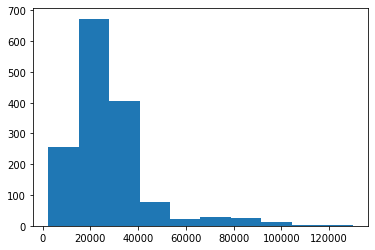

In [5]:
plt.hist(usedcarinfo['price'])
plt.show()

In [6]:
# model preperation
columns_to_drop=['make','model','price']
X=usedcarinfo.join(pd.get_dummies(usedcarinfo['model']))
X=X[ (X['year']>1999) & (X['price']<max(X['price'])) & (X['price']>min(X['price']))] # drop outliers
y=X['price']
X=X.drop(columns=columns_to_drop)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)

model_xgb=xgb.XGBRegressor(colsample_bytree=0.5, gamma=0.1, 
                             learning_rate=0.05, max_depth=3, 
                             min_child_weight=1, n_estimators=800,
                             subsample=0.5, verbosity=1,
                             random_state = 2, nthread = -1)
model_xgb.fit(X_train, y_train)
# evaluation
y_xgb = model_xgb.predict(X_test)

print('R^2 of the training set: {:.3f}'.format(model_xgb.score(X_train, y_train)))
print('R^2 of the test set: {:.3f}'.format(model_xgb.score(X_test, y_test)))

R^2 of the training set: 0.960
R^2 of the test set: 0.884


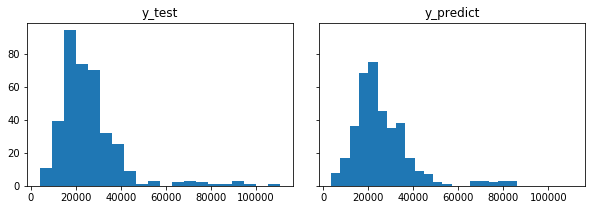

In [7]:
fig, axs = plt.subplots(1, 2,sharey=True,sharex=True, gridspec_kw={'hspace': 0, 'wspace': 0.1},figsize=(10,3))
axs[0].hist(y_test,bins=20)
axs[0].set_title('y_test')
axs[1].hist(np.sort(y_xgb),bins=20)
axs[1].set_title('y_predict')
plt.show()

In [8]:
# input a car info and output the predicted price
def inputinfo(yearin,milein,certin,modelin):
    inputdict={'year':yearin,'mileage':milein,'certified':certin,'model':modelin}
    inputdf=pd.DataFrame(columns=X.columns)
    for i in inputdict.keys():
        if i in inputdf.columns:
            inputdf[i]=[inputdict[i]]
        else:
            inputdf[inputdict[i]]=[1.0]
    return inputdf.fillna(0)

In [9]:
modelin=usedcarinfo.model.unique()[0] # first model in all models available
model_xgb.predict(inputinfo(2020,30000,0,modelin))

array([33818.594], dtype=float32)

In [10]:
# input your budget range (lb,hb), output the number of recommendations
def good_deals(lb,hb,num_results=10):
    ypred=model_xgb.predict(X)
    ydif=[] # (index,real, real - predicted)
    for i in range(len(y)):
        yindex=y.index[i]
        if (y.iloc[i]-ypred[i] < 0) and (y.iloc[i] < hb) and (y.iloc[i] > lb):
            ydif+=[[yindex,y.iloc[i],y.iloc[i]-ypred[i]]]
    good_index=list(list(zip(*sorted(ydif,key=lambda x:x[2])))[0][:num_results]) # sort by the third column, * for transpose, zip the first row(index), '[0]' returns index, convert to list
    return usedcarinfo.loc[good_index].reset_index().drop(columns=['index'])

In [11]:
good_deals(15000,30000)

,make,year,model,mileage,certified,price
0,Jeep,2020,Cherokee,100,0,25998
1,Jeep,2014,Grand,17551,0,19499
2,Jeep,2015,Wrangler,18098,0,25077
3,Jeep,2017,Wrangler,31000,0,25000
4,Jeep,2016,Wrangler,27203,0,21000
5,Jeep,2015,Wrangler,60500,0,23000
6,Jeep,2018,Wrangler,20958,0,27590
7,Jeep,2016,Wrangler,39414,0,23700
8,Jeep,2016,Wrangler,53870,0,23742
9,Jeep,2015,Wrangler,51199,0,24675
